# Bias-Variance trade-off for Monte-Carlo methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

# 1. Defining the environment

We study the 1000-steps random walk (ex 9.1 in Sutton's book).

The discounting factor is $\gamma$, and $\pi$ is the policy to be evaluated.

In [2]:
#discount factor
gamma=0.9 #numerically, this is roughly equivalent to setting gamma=1

#define number of states
nState=1000

#define policy
#random walk, move 1 to 100 steps to the left or to the right
P_pi = np.zeros((nState+1,nState+1))
nStep=100

for i in range(1,nStep+1):
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(nState+1-i),i)
    P_pi+=(1.0/(nStep*2.0)) * np.diag(np.ones(nState+1-i),-i)

P_pi[0,:]=0
P_pi[:,0]=0
P_pi[0,0]=1

for i in range(0,nStep):
    P_pi[i+1,0]=0.5-(i)/(2.0*nStep)
    P_pi[nState-i,0]=0.5-(i)/(2.0*nStep)


#define reward vector
#reward of +1 if reach right end, -1 if reach left end
r_pi=np.zeros(nState+1)
for i in range(0,nStep):
    r_pi[i+1]=-(0.5-(i)/(2.0*nStep))
    r_pi[nState-i]=0.5-(i)/(2.0*nStep)


#compute true value function v_pi
#we compute exact valeus by inverting the transition matrix
v_pi = np.linalg.solve( (np.eye(nState+1)-gamma*P_pi),r_pi)

    
#number of aggregated states
k=10

#define Phi matrix
# /!\ for the following formula to work correctly, k must be divider of nState /!\
Phi=np.vstack((np.zeros(k),np.kron(np.eye(k),np.ones((nState/k,1)))))
u=np.zeros(nState+1).reshape((nState+1,1))
u[0]=1
Phi=np.hstack((u,Phi))

Denote $d$ the stationnaty distribution of states under $\pi$. We define $D$ as the diagonal matrix which diagonal entries are $d$ :

$$
D = 
\left(
\begin{array}{ccc}
d(s_{1}) & & 0\\
& \ddots & \\
0 & & d(s_{|\mathcal{S}|})
\end{array}
\right)
$$

Then, by definition of $d$, we have $d^{T} = d^{T} P$, or $d = P^{T} d$. That is, $d$ is an eigenvector of $P^{T}$ associated to eigenvalue $1$.

Note that, because $(I-P)$ is singular, we can't just write $d = (I-P)^{-1}$.

In [3]:
#compute stationary distribution
#Recall state 0 is terminal and absorbent under policy pi
#If we just apply the above formula, ie $d^T = d^T P$, we will get d = [1 0 0 0 0 ...]
#Therefore, we slightly tweak the transition matrix, by adding a deterministic transition 
#from the terminal state to the initial state

#Note that this works with any distribution for the initial state
#However, a different distribution of initial state will yield a different stationary distribution
P_pi[0,0]=0
P_pi[0,nState/2]=1

#this will typically yield complex eigenvectors
[e,v]=np.linalg.eig(P_pi.T)
d_=np.abs(v[:,0])/np.sum(np.abs(v[:,0])) #don't forget to normalize

#compute D matrix
D=np.diag(d_)

#cancel modifications
P_pi[0,:]=0
P_pi[0,0]=1

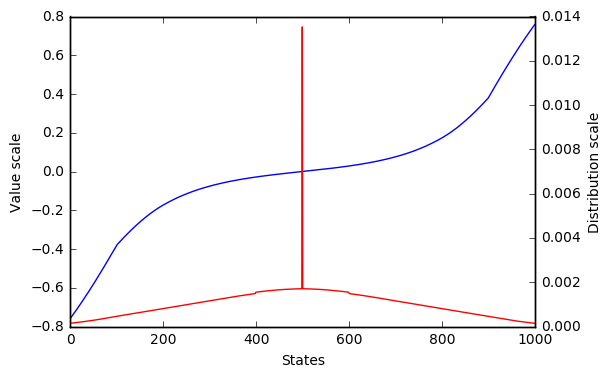

In [4]:
#Here we plot the stationary distribution and value function
#we don't plot state 0 as it is the terminal state (thus its value is 0)

fig, ax1 = plt.subplots()
#plot value function
ax1.plot(v_pi[range(1,nState+1)],'b-')
ax1.set_xlabel('States')
ax1.set_ylabel('Value scale')
#plot stationary distribution
ax2 = ax1.twinx()
ax2.plot(d_[range(1,nState+1)],'r')
ax2.set_ylabel('Distribution scale')

#fig.tight_layout()
plt.show()

The stationary distribution $d$ is used to compute the Mean Square Value Error (MSVE). For a given state $s$, the error for that state is weighted by how often it is visited under policy $\pi$. In other words, precision matters less for state that aren't visited much.

The Mean Squared Value Error is actually a scalar product, so it can be computed using matrix multiplication :

\begin{align}
MSVE(\theta) & = \sum_{s} d(s) \Big( \hat{v}(\theta,s)-v_{\pi}(s) \Big)^{2} \\
& = (\hat{v} - v_{\pi})^{T} \cdot D \cdot (\hat{v} - v_{\pi}) \\
& = (\Phi \theta - v_{\pi})^{T} \cdot D \cdot (\Phi \theta - v_{\pi})
\end{align}

In the following, we denote $<\cdot,\cdot>_{D}$ the $D$-scalar product defined below, and $\| \cdot \|_{D}$ the associated norm:
\begin{align}
<u,v>_{D} & = u^{T} \cdot D \cdot v \\
\| u \|_{D}^{2} & = u^{T} \cdot D \cdot u
\end{align}

In [5]:
def MSVE(theta,D,Phi,v_pi):
    v_hat=Phi.dot(theta)
    return (v_hat-v_pi).T.dot(D).dot(v_hat-v_pi)

In [6]:
#define A matrix
A=Phi.T.dot(D).dot(Phi)
[e_A,v_A]=np.linalg.eig(A)

# 1. On-policy prediction with tabular representation

Here we study the bias-variance trade-off for MC prediction. We start by only looking at one single state

Denote $v_{\pi}$ the value function we try to predict. Recall the update rule for semi-gradient MC:
$$
v_{t+1} = v_{t} + \alpha \left[ G_{t} - \phi_{t}^{T}v_{t} \right] \cdot \phi_{t}
$$
from which we derive, considering a given state $s$:
\begin{align}
v_{t+1}(s) &= v_{t}(s) + \alpha \left[ G_{t} - v_{t}(s) \right]\\
&= (1-\alpha)v_{t}(s) + \alpha G_{t}
\end{align}
where $t$ now denotes the number of visits to state $s$.

In [7]:
#Here, we implement a first-visit, semi-gradient Gradient MC Algorithm for the state-value prediction

#the state of interest
param=400

#number of episodes
nEp_mc=1000
#number of runs
nbRuns_mc=10000

alpha_mc=0.01 #I selected this learning rate so that the graphs look nice

print 'Starting MC simulation:',nbRuns_mc,'runs; ', nEp_mc,'episodes/run'

#initialize parameters
v_approx =np.zeros((nbRuns_mc,nEp_mc+1))
v_approx1=np.zeros((nbRuns_mc,nEp_mc+1))
v_approx2=np.zeros((nbRuns_mc,nEp_mc+1))

#this will be used to estimate the returns' variance
returns=[]

print 'Run', 0,'/',nbRuns_mc
for r in range(nbRuns_mc):
    
    #print the runs progression
    if(nbRuns_mc>1 and ((r+1) % (nbRuns_mc/10) == 0)):
        print 'Run', r+1,'/',nbRuns_mc
    
    for e in range(1,nEp_mc+1):
         
        #print episodes progression only if 1 single run is performed
        if(nbRuns_mc==1 and ((e) % (nEp_mc/10) == 0)):
            print e,'/',nEp_mc

        #generate an episode
        c=0
        n_=250
        u_=np.array([param])
        while(c==0):
            u_=np.append(u_,(1+np.random.randint(0,nStep,n_))*(1-2*(np.random.rand(n_)<0.5)))
            u=np.cumsum(u_)
            c=np.argmin(1-np.any([(u>nState),(u<=0)],axis=0))

        s=u[c] #final state
        #u=u[range(c)]

        #compute reward
        G=(1-2*(s<=0)) #-1 if s<0

        #apply MC update
        g=gamma**(c-1)
        v_approx[r,e] = v_approx[r,e-1] + alpha_mc * (g*G-v_approx[r,e-1])
        
        #here we look at the impact of decreasing the learning rate
        alpha1 = alpha_mc/(0.001+e)
        alpha2 = alpha_mc/(0.001+e*e) #this one is decreased too fast : bias won't go to 0
        
        v_approx1[r,e] = v_approx1[r,e-1] + alpha1 * (g*G-v_approx1[r,e-1])
        v_approx2[r,e] = v_approx2[r,e-1] + alpha2 * (g*G-v_approx2[r,e-1])
        
        returns.append(g*G)
        
var_returns=np.var(returns)

Starting MC simulation: 10000 runs;  1000 episodes/run
Run 0 / 10000
Run 1000 / 10000
Run 2000 / 10000
Run 3000 / 10000
Run 4000 / 10000
Run 5000 / 10000
Run 6000 / 10000
Run 7000 / 10000
Run 8000 / 10000
Run 9000 / 10000
Run 10000 / 10000


In [8]:
#Compute empirical biases
bias_emp  = np.mean(v_approx,0) -v_pi[param]
bias_emp1 = np.mean(v_approx1,0)-v_pi[param]
bias_emp2 = np.mean(v_approx2,0)-v_pi[param]

#compute empirical variance
var_emp =np.var(v_approx,0)
var_emp1=np.var(v_approx1,0)
var_emp2=np.var(v_approx2,0)

## 1.1 Bias

We start by studying the evolution of the bias over time.

Denote $\epsilon_{t} = \mathbb{E}[v_{t}(s)-v_{\pi}(s)]$ the bias after $t$ visits. The update rule then yields:
\begin{align*}
\epsilon_{t+1} &= \mathbb{E}[ v_{t+1}(s)- v_{\pi}(s) ]\\
&= \mathbb{E}[ (1-\alpha)v_{t}(s) + \alpha G_{t} - v_{\pi}(s)]\\
&= \mathbb{E}[ (1-\alpha)(v_{t}(s)-v_{\pi}(s) ) + \alpha (G_{t}- v_{\pi}(s))]\\
&= (1-\alpha) \epsilon_{t}\\
&= (1-\alpha)^{t+1} \epsilon_{0}
\end{align*}

We see the bias decreases geometrically at rate $(1-\alpha)$. A larger learning rate $\alpha$ leads to faster decrease in the bias.

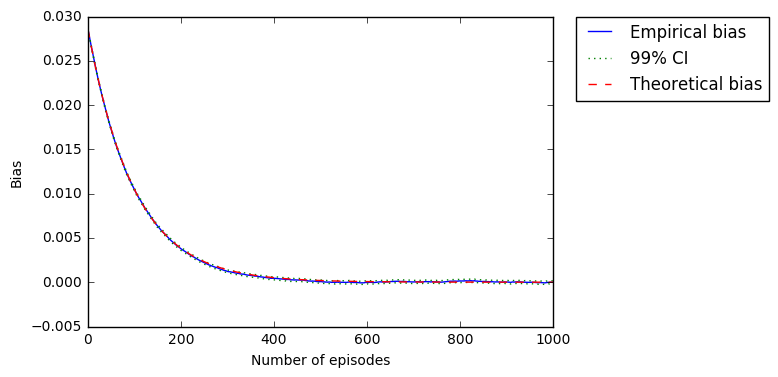

In [9]:
#Numerical experiment: theoretical vs empirical bias, with CI

#compute 99% confidence intervals for the true bias
bias_CI_lo=bias_emp-2.58*np.std(v_approx,0)/np.sqrt(nbRuns_mc)
bias_CI_hi=bias_emp+2.58*np.std(v_approx,0)/np.sqrt(nbRuns_mc)

#compute theoretical bias
bias_theo = (-v_pi[param])*np.power( (1-alpha_mc),np.arange(nEp_mc+1))

plt.plot(bias_emp,'b-',label='Empirical bias')
plt.plot(bias_CI_lo,'g:',label='99% CI')
plt.plot(bias_CI_hi,'g:')
plt.plot(bias_theo,'r--',label='Theoretical bias')
plt.xlabel('Number of episodes')
plt.ylabel('Bias')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 1.2 Variance

Here, we look at the variance of the estimates.

From the update rule, we get :
\begin{align*}
V[ v_{t+1}(s) ] &= V[(1-\alpha)v_{t}(s) + \alpha G_{t}]\\
&= (1-\alpha)^{2} V[v_{t}(s)] + \alpha^{2} V[G_{t}]
\end{align*}

since $G_{t}$ and $v_{t}(s)$ are independant. Notice that $V[G_{t}]$ does not depend $t$. It is the intrinsic variance of the return that follows a visit to state $s$, we denote it $\tilde{V}$. 

Expanding the above formula, we get:
$$
V_{t} = (1-\alpha)^{2t} V_{0} + \alpha^{2}  \sum_{k=0}^{t-1} (1-\alpha)^{2k} \tilde{V}
$$
with $V_{t}=V[ v_{t}(s) ]$

Setting the initial estimate $v_{0}=0$ yields $V[v_{0}(s)]=0$. Finally, we have :
$$
V_{t} = \frac{\alpha}{2-\alpha} \left(1-(1-\alpha)^{2t} \right) \tilde{V}
$$

Asymptotically, as $t$ goes to infinity, we are left with:
$$
V_{\infty} = \frac{\alpha}{2-\alpha} \tilde{V}
$$

As we can see, although it can be made arbitrarily small, the variance does not go to $0$, even after an infinite number of iterations. We will see later that this result holds even if $\alpha$ is decreased over time.
This is not the case with the naive Monte-Carlo implementation, where returns are simply averaged over time.

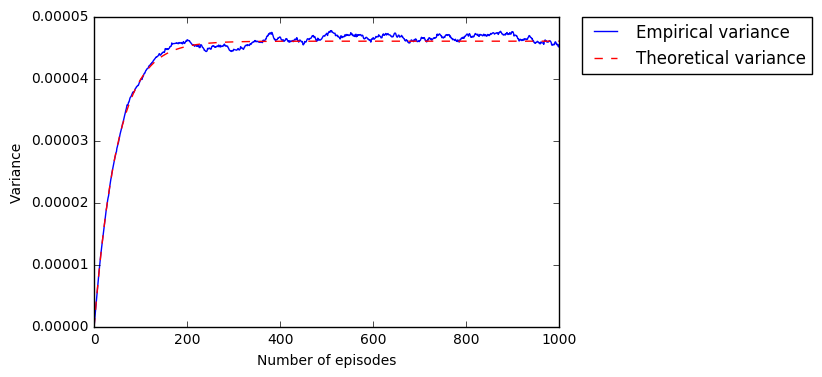

In [10]:
#Numerical experiment: theoretical vs empirical variance

#compute theoretical variance
#recall that V_0 = 0
var_theo = (alpha_mc/(2.0-alpha_mc))*var_returns*(1.0-np.power(1-alpha_mc,2*np.arange(nEp_mc+1)))

plt.plot(var_emp,'b-',label='Empirical variance')
plt.plot(var_theo,'r--',label='Theoretical variance')
plt.xlabel('Number of episodes')
plt.ylabel('Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 1.3 Mean Squared Error

The Mean Squared Error (MSE) is defined as :
\begin{align}
MSE(v_{t}(s)) &= \mathbb{E} [(v_{t}(s)-v_{\pi}(s))^{2}]\\
&= V[v_{t}(s)] + \mathbb{E} [v_{t}(s)-v_{\pi}(s)] ^{2} \\
&= V_{t} + \epsilon_{t}^{2}
\end{align}

Assuming $v_{0}(s)=0$, then we have:
\begin{align}
MSE_{t} &= V_{t} + \epsilon_{t}^{2}\\
&= \frac{\alpha}{2-\alpha} \left[ 1-(1-\alpha)^{2t} \right] \tilde{V} + (1-\alpha)^{2t} v_{\pi}(s)^{2}
\end{align}

Asymptotically, as $t$ goes to infinity, we are left with:
$$
MSE_{\infty} = \frac{\alpha}{2-\alpha} \tilde{V}
$$

The forumla $MSE_{t} = V_{t} + \epsilon_{t}^{2}$ offers a natural visualization of the bias/variance tradeoff. 

In the figure below, the progression of the MC method is represented in the bias/variance plane. The first estimate have only bias and no variance. As time goes, the bias decreases while the variance increases, resulting in an overall reduction of the MSE.

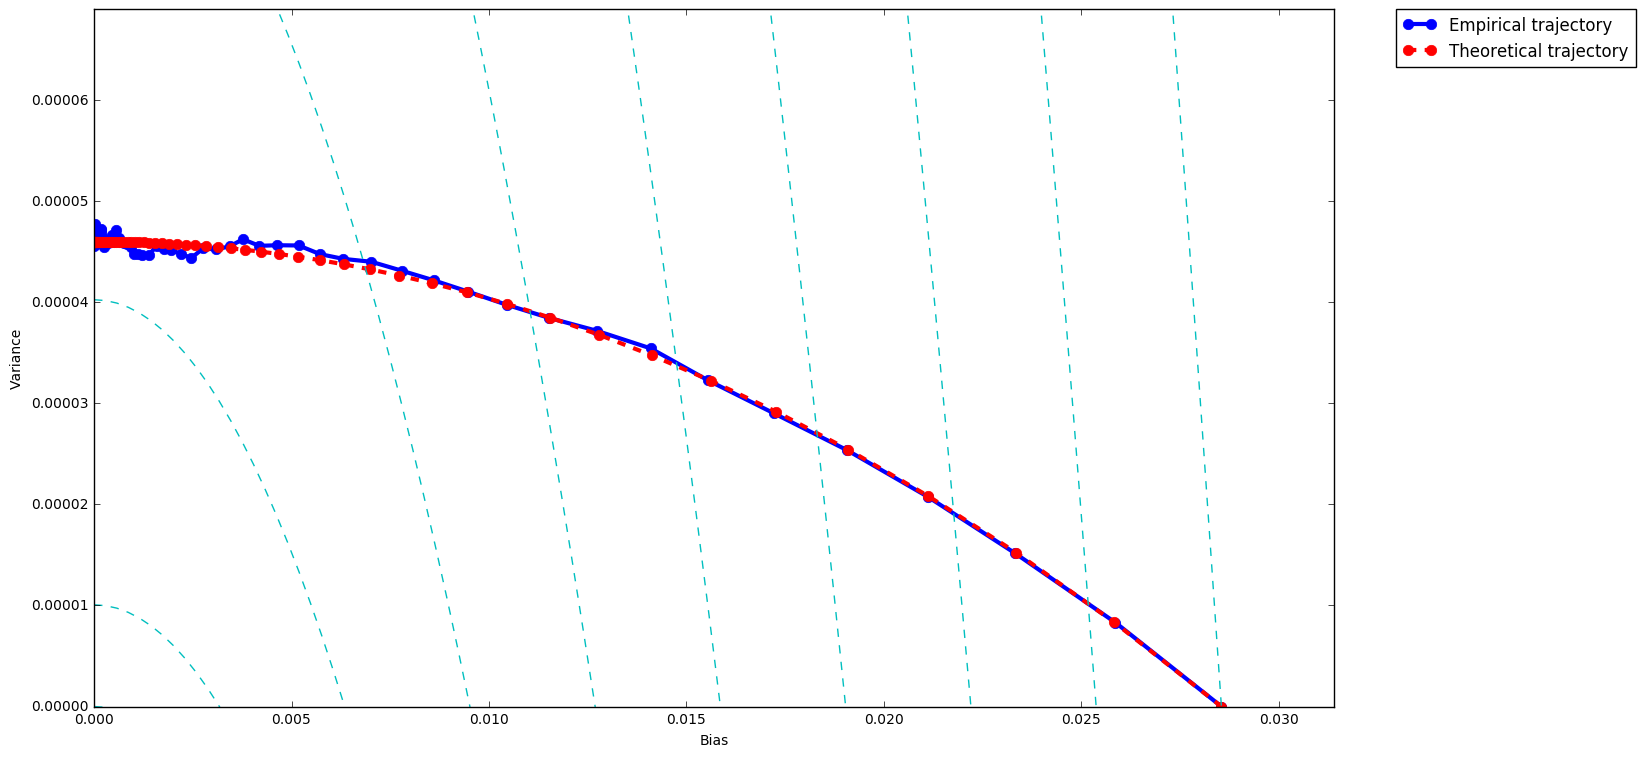

In [14]:
#Numerical experiment: bias/variance trajectory with MSE contour lines


bias_naive=np.zeros(nEp_mc+1)
var_naive=var_returns/(1.0+5*np.arange(nEp_mc+1))

subset=10*np.arange(nEp_mc/10)

#draw bias/variance trade-off
plt.figure(figsize=(16,9))
plt.plot(bias_emp[subset],var_emp[subset],color='b',lw=3,marker='.',ms=15,label='Empirical trajectory')
plt.plot(bias_theo[subset],var_theo[subset],color='r',ls='--',lw=3,marker='.',ms=15,label='Theoretical trajectory')
#plt.plot(bias_naive[subset],var_naive[subset],color='r',lw=3,marker='.',ms=15,label='Naive trajectory')


#draw MSE level lines
x_min=np.min(bias_theo)
x_max=np.max(np.abs(bias_theo))
y_min=np.min(var_theo)
y_max=np.max(var_theo)
#z_min=np.min(mse_theo)
#z_max=np.max(mse_theo)

x=np.linspace(0,x_max,100)
for z in np.square(np.linspace(0,x_max,10)):
    plt.plot(x,z-np.square(x),color='c',ls='--')

plt.axis([0,1.1*x_max,0,1.5*y_max])
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 1.4 The influence of $\alpha$

We now study how the learning rate $\alpha$ influences the bias/variance trade-off.

### 1.4.1 Constant learning rate

First, assuming a constant $\alpha$, one may wonder how best to choose this learning rate. Recall the analytical formula for the mean squared error after $t$ updates :
$$
MSE_{t} = \frac{\alpha}{2-\alpha} \left[ 1-(1-\alpha)^{2t} \right] \tilde{V} + (1-\alpha)^{2t} v_{\pi}(s)^{2}
$$

It is easy to see that 
* the left-hand term $\frac{\alpha}{2-\alpha} \left[ 1-(1-\alpha)^{2t} \right] \tilde{V}$ is an increasing function of $\alpha$. It ranges from $0$ when $\alpha=0$, to $\tilde{V}$ when $\alpha=1$
* the right-hand term $(1-\alpha)^{2t} v_{\pi}(s)^{2}$ is a decreasing function of $\alpha$. It ranges from $v_{\pi}(s)^{2}$ when $\alpha=0$ down to $0$ when $\alpha=1$.

For a given $t$, the optimal value of $MSE_{t}$ can be computed numerically, by finding a root of the derivative.

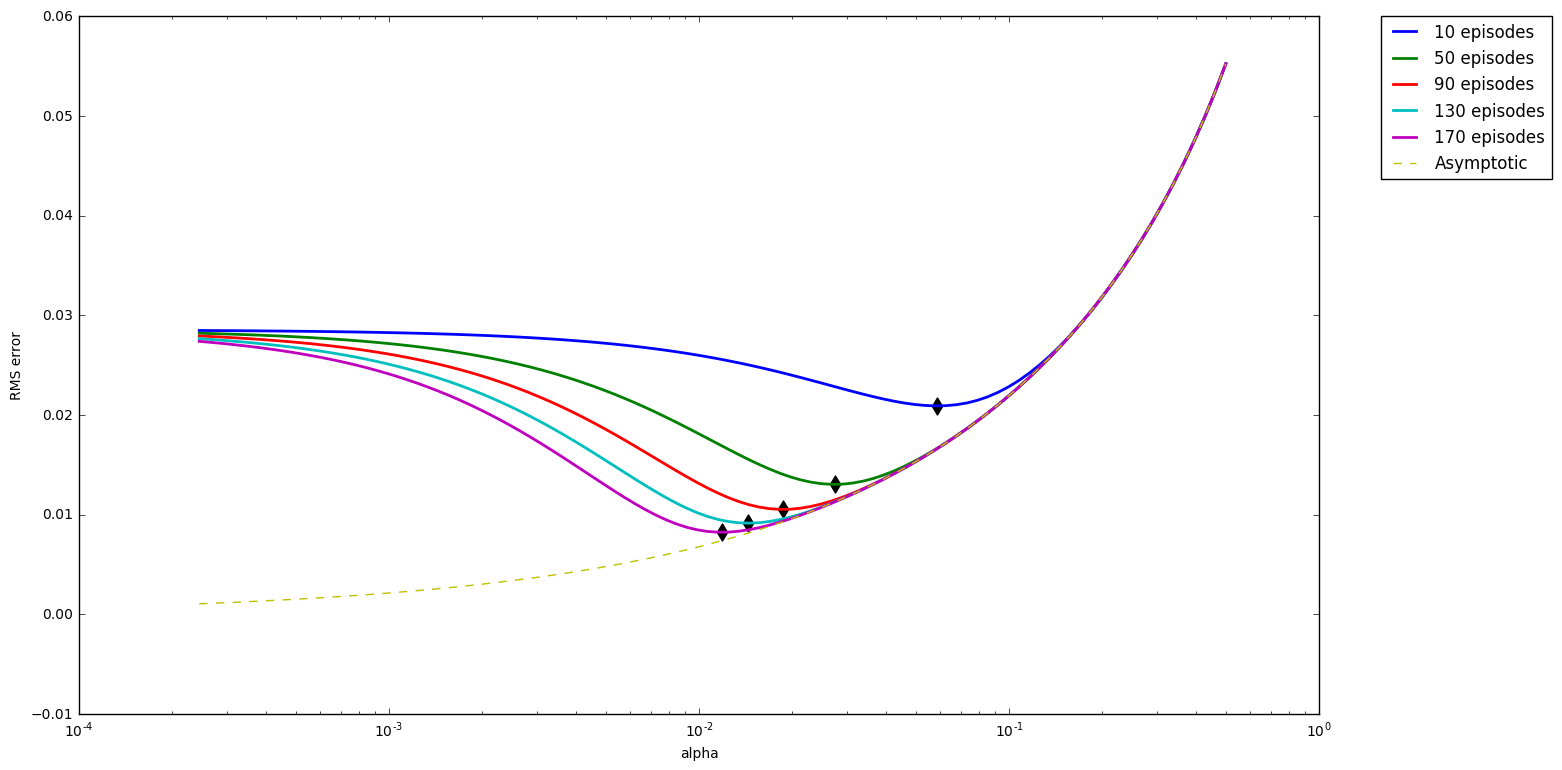

In [15]:
a=np.power(2.0,np.linspace(-12,-1,100))

plt.figure(figsize=(16,9))

for t in (10+40*np.arange(5)):
    mse=(a/(2-a))*(1-np.power(1-a,2*t))*var_returns + v_pi[param]**2 * np.power(1-a,2*t)
    rmse=np.sqrt(mse)
    plt.semilogx(a,rmse,lw=2,label=(str(t)+' episodes'))
    
    #compute optimal alpha
    V=var_returns
    v=v_pi[param]
    
    #b=1-a
    f=lambda b: ((1-b)/(1+b))*(1-b**(2*t))*V+v*v*(b**(2*t))
    g=lambda b: (1.0-b**(2*t))/(t*(1.0+b)*(1.0+b)*(b**(2*t-1)))+(1.0-b)/(1.0+b)-v*v/V
    
    #actually, the analytical value seems horrible to get, so I just compute the optimum numerically
    b_opt=fsolve(g,0.99)
    plt.scatter(1-b_opt,np.sqrt(f(b_opt)),marker='d',color='k',s=75)

    

plt.plot(a,np.sqrt(var_returns*a/(2-a)),ls='--',label='Asymptotic')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('alpha')
plt.ylabel('RMS error')
plt.show()

### 1.4.2 Dynamic learning rate

We do not assume that the learning rate is constant anymore. Therefore, we denote $\alpha_{t}$ the learning rate used in the $t^{th}$ update :
\begin{align}
v_{t+1}(s) &= v_{t}(s) + \alpha_{t} \left[ G_{t} - v_{t}(s) \right]\\
&= (1-\alpha_{t})v_{t}(s) + \alpha_{t} G_{t}
\end{align}
and we assume that $0 \leq \alpha_{t} <1 $

The previous formulas are then re-written as :
\begin{align*}
\epsilon_{t+1} &= \prod_{i=0}^{t} (1-\alpha_{i}) \epsilon_{0}\\
V_{t+1} &= \prod_{i=0}^{t-1} (1-\alpha_{i})^{2} V_{0} + \sum_{i=0}^{t-1} \left( \alpha_{i}^{2} \prod_{k=0}^{i-1} (1-\alpha_{k})^{2} \right) \tilde{V}
\end{align*}

These two relations can be written under matrix form:
$$
\left(
\begin{array}{c}
V_{t+1}\\
\epsilon_{t+1}\\
\tilde{V}
\end{array}
\right)
=
\left(
\begin{array}{ccc}
(1-\alpha_{t})^2 & 0 & \alpha_{t}^{2}\\
0 & (1-\alpha_{t}) & 0\\
0 & 0 & 1
\end{array}
\right)
\left(
\begin{array}{c}
V_{t}\\
\epsilon_{t}\\
\tilde{V}
\end{array}
\right)
$$

which is useful to speed-up computations. The above matrix will be denoted $M_{\alpha_{t}}$.

Let us look at the convergence:

First, the bias $\epsilon_{t}$ goes to $0$ if and only if $\ln{| \epsilon_{t} |}$ goes to minus infinity:
\begin{align*}
\ln |\epsilon_{t+1}| &= \ln | \prod_{i=0}^{t} (1-\alpha_{i}) \epsilon_{0} | \\
&=\sum_{i=0}^{t} \ln (1-\alpha_{i}) + \ln |\epsilon_{0} |\\
\end{align*}
The Taylor expansion : $\ln(1-\alpha) = -\alpha + O(\alpha^{2})$ gives us :
\begin{align*}
\ln |\epsilon_{t+1}| &=\sum_{i=0}^{t} \left( -\alpha_{i} + O(\alpha_{i}^{2}) \right) + \ln |\epsilon_{0} |\\
&=-\sum_{i=0}^{t} \alpha_{i} + O\left( \sum_{i=0}^{t} \alpha_{i}^{2} \right) + \ln |\epsilon_{0} |\\
\end{align*}

The following two conditions are sufficient to ensure the bias goes to $0$ :

\begin{align}
\sum_{t \geq 0} \alpha_{t} & = +\infty\\
\sum_{t \geq 0} \alpha_{t}^{2} & < +\infty\\
\end{align}

Indeed, we then have $O\left( \sum_{i=0}^{t} \alpha_{i}^{2} \right)+\ln |\epsilon_{0} |=O(1)$, where the domination is with respect to $t$. Consequently, we have the following :
$$
\lim_{t \rightarrow \infty} \ln |\epsilon_{t}| = \lim_{t \rightarrow \infty} \sum_{t \geq 0} \alpha_{t} +O(1)= -\infty
$$
and the bias thus goes to $0$

Second, let us prove thatthe variance converges, under the same assumptions on the sequence $(\alpha_{t})$.

Recall:
$$
V_{t+1} = \prod_{i=0}^{t-1} (1-\alpha_{i})^{2} V_{0} + \sum_{i=0}^{t-1} \left( \alpha_{i}^{2} \prod_{k=0}^{i-1} (1-\alpha_{k})^{2} \right) \tilde{V}
$$

* The first term $\prod_{i=0}^{t-1} (1-\alpha_{i})^{2} V_{0}$ converges, since $V_{0}$ is finite, and $\prod_{i=0}^{t-1} (1-\alpha_{i})^{2}$ is a positive, decreasing sequence. Notice its limit is non-negative.


* The second also converges. Indeed, it is a positive, increasing sequence, and we have the following bound:

$$
\sum_{i=0}^{t-1} \left( \alpha_{i}^{2} \prod_{k=0}^{i-1} (1-\alpha_{k})^{2} \right) \tilde{V} \leq \sum_{i=0}^{t-1}  \alpha_{i}^{2} \tilde{V} \leq \sum_{t\geq 0} \alpha_{t}^{2} \tilde{V}
$$
which we derive from our second assumption on $(\alpha_{t})$. Since the second term is positive, its limit is also positive.


* Finally, we have the following upper bound on the asymptotic variance:

$$
\boxed{\ \ \ 
\large{V_{\infty} \leq V_{0} + \sum_{t\geq 0} \alpha_{t}^{2} \tilde{V}}
\ \ \ }
$$

It is interesting to see that, even if the learning rate is decreased to $0$, the variance never goes to $0$. 

If we assume that $V_{0}=0$, which is the case when we set $v_{0}(s)=0$, then the variance actually increases over time, while the bias decreases.

In [16]:
#Compute theoretical biases corresponding to alpha1 and alpha2
#recall alpha1 = alpha_mc/ e ; alpha2 = alpha_mc/ (e*e) where e is the episode

bias_theo1=(-v_pi[param])*np.ones(nEp_mc+1)
bias_theo2=(-v_pi[param])*np.ones(nEp_mc+1)

var_theo1=np.zeros(nEp_mc+1)
var_theo2=np.zeros(nEp_mc+1)

for e in range(1,nEp_mc+1):
    alpha1=alpha_mc/(0.001+e)
    alpha2=alpha_mc/(0.001+e*e)
    
    bias_theo1[e]=(1-alpha1)*bias_theo1[e-1]
    bias_theo2[e]=(1-alpha2)*bias_theo2[e-1]
    
    var_theo1[e]=((1-alpha1)**2)*var_theo1[e-1]+(alpha1**2) * var_returns
    var_theo2[e]=((1-alpha2)**2)*var_theo2[e-1]+(alpha2**2) * var_returns

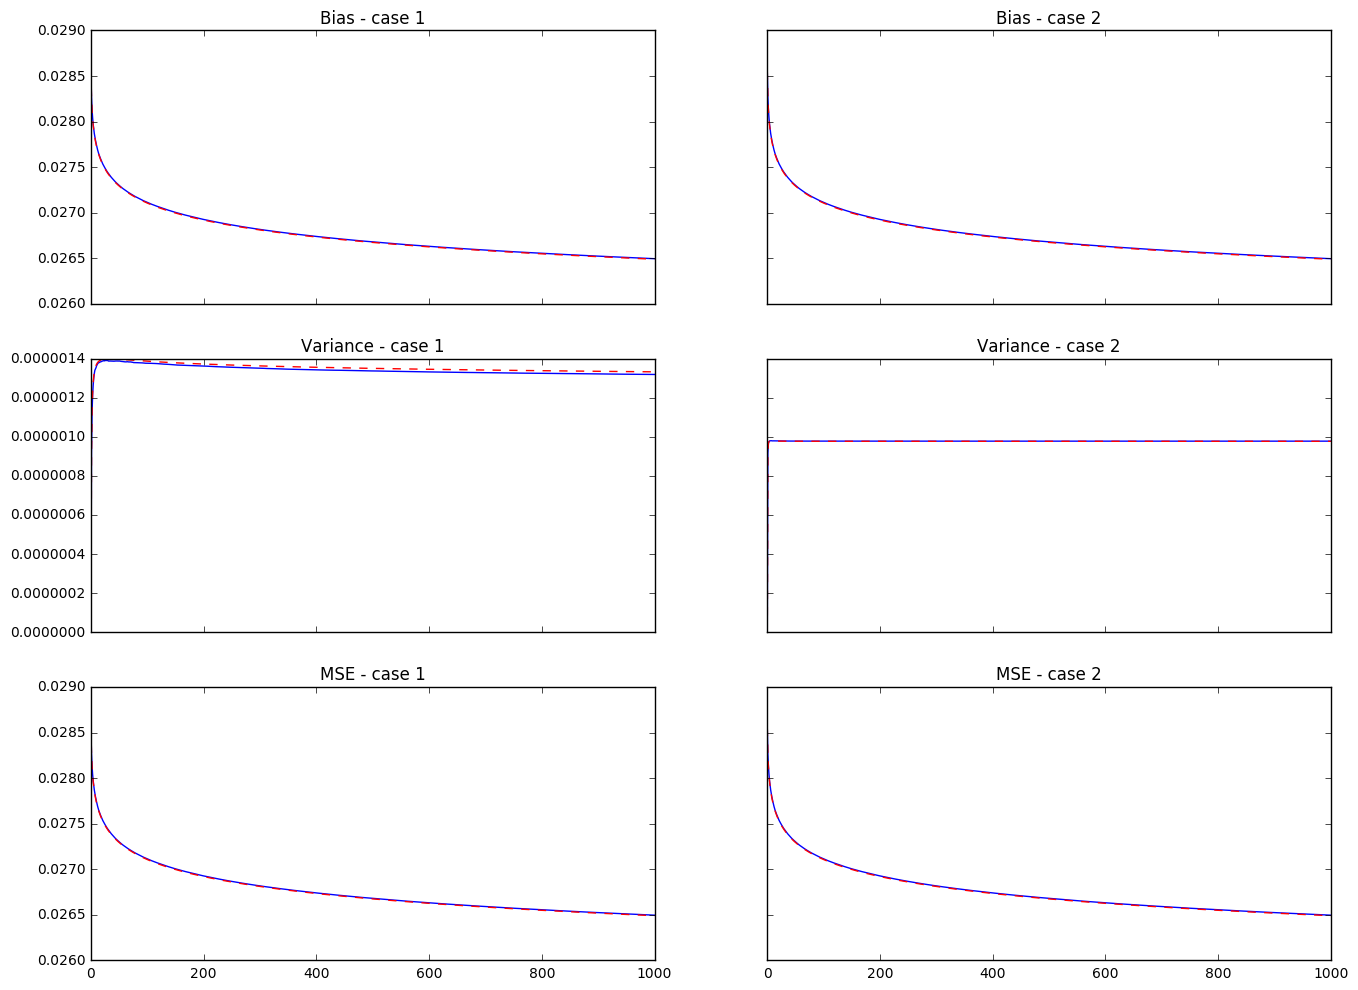

In [17]:
#Now, we look at the effect of decreasing the learning rate over time

f, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, sharex='col',sharey='row',figsize=(16,12))

ax1.plot(bias_emp1,color='b',label='Empirical bias')
ax1.plot(bias_theo1,color='r',ls='--',label='Theoretical bias')
ax1.set_title('Bias - case 1')

ax2.plot(bias_emp1,color='b',label='Empirical bias')
ax2.plot(bias_theo1,color='r',ls='--',label='Theoretical bias')
ax2.set_title('Bias - case 2')

ax3.plot(var_emp1,color='b',label='Empirical variance')
ax3.plot(var_theo1,color='r',ls='--',label='Theoretical variance')
ax3.set_title('Variance - case 1')

ax4.plot(var_emp2,color='b',label='Empirical variance')
ax4.plot(var_theo2,color='r',ls='--',label='Theoretical variance')
ax4.set_title('Variance - case 2')

ax5.plot(bias_emp1,color='b',label='Empirical MSE')
ax5.plot(bias_theo1,color='r',ls='--',label='Theoretical MSE')
ax5.set_title('MSE - case 1')

ax6.plot(bias_emp1,color='b',label='Empirical MSE')
ax6.plot(bias_theo1,color='r',ls='--',label='Theoretical MSE')
ax6.set_title('MSE - case 2')

plt.show()

# 2. On-policy prediction with linear approximation

We now look at the case of linear function approximation.

The MC bias can be computed analytically quite easily. The variance, however... Therefore, we only present theoretical results for the behaviour of the bias.

Recall the update rule for $\theta$ in Monte-Carlo method:
\begin{align}
\theta_{t+1} & = \theta_{t} + \alpha \left[ G_{t} - \theta_{t}^{T} \cdot \phi_{t} \right] \cdot \phi_{t} \\
& = \theta_{t} + \alpha \left[ G_{t} \phi_{t}  - (\phi_{t} \phi_{t}^{T})  \theta_{t} \right] 
\end{align}

and thus, in the steady state :
\begin{align}
\bar{\theta}_{t+1} & = \bar{\theta}_{t} + \alpha \left[ \mathbb{E} [G_{t} \phi_{t}] - \mathbb{E} [\phi_{t} \phi_{t}^{T}] \bar{\theta}_{t} \right] \\
& = \bar{\theta}_{t} + \alpha \left[ \Phi^{T} D \cdot v_{\pi} - \Phi^{T} D  \Phi \cdot \bar{\theta}_{t} \right]\\
&= \bar{\theta}_{t} + \alpha \left[ b - A \cdot \bar{\theta}_{t} \right]
\end{align}
where
\begin{align}
A &= \Phi^{T}  D \cdot \Phi\\
b &= \Phi^{T}  D \cdot v_{\pi} \\
\end{align}

Therefore, we have asymptotically:
$$
\theta_{MC} = (\Phi^{T} D \Phi)^{-1} \Phi^{T} D \cdot v_{\pi}
$$

and finally :
$$
\large{\Pi v_{\pi} = \Phi \cdot \theta_{MC}}
$$

Notice that $\Phi \theta_{MC}$ is a global minimizer of the MSVE:
\begin{align}
MSVE(\theta) & = \| v_{\pi} - \Phi \theta  \|_{D}^{2}\\
& \leq \| v_{\pi} - \Pi v_{\pi} \|_{D}^{2} \\
& = \| v_{\pi} - \Phi \theta_{MC} \|_{D}^{2} \\
& = MSVE(\theta_{MC})
\end{align}

In [18]:
#Compute theoretical MC fixed-point
theta_mc_star = np.linalg.inv(np.linalg.multi_dot((Phi.T,D,Phi))).dot(Phi.T).dot(D).dot(v_pi)
#compute approximated value function
v_mc=Phi.dot(theta_mc_star)

#compute MSVE for Monte Carlo
mmc=MSVE(theta_mc_star,D,Phi,v_pi)

In [19]:
#Since now we compute the whole value function, we reduce the number of episodes and runs
nEp_mc=1000 #number of episodes
nbRuns_mc=100 #number of runs
alpha_mc=2*10**(-3) #learning rate

Denote $\epsilon_{t}$ the bias vector at iteration $t$ :
$$
\epsilon_{t} = \mathbb{E}[\theta_{t}-\theta_{MC}] = \bar{\theta}_{t}-\theta_{MC}
$$

From the update rule, we derive:
$$
\epsilon_{t+1} = (I-\alpha A) \epsilon_{t} = (I-\alpha A)^{t} \epsilon_{0}
$$

In [20]:
#Theoretical bias is much faster to compute, as it is obtained through matrix mutliplication
bias_mc_exp=np.zeros((nEp_mc,k+1))
bias_mc_exp[0,:]=-theta_mc_star
B=np.power((np.eye(k+1)-alpha_mc*A),83) #on average, 83 steps are made per episode
for e in range(1,nEp_mc):
    bias_mc_exp[e,:]=B.dot(bias_mc_exp[e-1,:])

    
theta_mc_exp = bias_mc_exp+theta_mc_star
v_mc_exp=(Phi.dot(theta_mc_exp.T)).T

In [21]:
#Gradient MC Algorithm
#d_mc=np.zeros(nState+1) #counts how many times each state is visited

MSVE_mc=np.zeros((nbRuns_mc,nEp_mc))
theta_save_mc=np.zeros((nbRuns_mc,nEp_mc,k+1))
counter=np.zeros((nbRuns_mc,nEp_mc))

print 'Starting MC simulation //', nbRuns_mc, 'runs ;', nEp_mc,'episodes/run'

print 0,'/',nbRuns_mc
for r in range(nbRuns_mc):
    if( (nbRuns_mc/10 >0) and (r+1) % (nbRuns_mc/10) == 0):
        print r+1,'/',nbRuns_mc
    
    #initialize weights
    theta_mc_approx=np.zeros(k+1)
    
    for e in range(nEp_mc):
        
        if((nbRuns_mc==1) and ((e+1) % (nEp_mc/10) == 0)):
            print e+1,'/',nEp_mc
            

        #generate an episode
        c=0
        n_=250
        u_=np.array([nState/2])
        while(c==0):
            u_=np.append(u_,(1+np.random.randint(0,nStep,n_))*(1-2*(np.random.rand(n_)<0.5)))
            u=np.cumsum(u_)
            c=np.argmin(1-np.any([(u>nState),(u<=0)],axis=0))
        
        s=u[c] #final state
        u=u[range(c)]
        counter[r,e]=c
        
        #compute reward
        G=(1-2*(s<=0)) #-1 if s<0

        #apply MC backup
        g=1
        for s in reversed(u):
            theta_mc_approx = theta_mc_approx + alpha_mc * (g*G-np.dot(theta_mc_approx,Phi[s,:]))*(Phi[s,:])
            g=gamma*g

        #compute approximated value function
        #v_mc_approx=np.dot(Phi,theta_mc_approx)

        #compute MSVE
        #MSVE_mc[r,e] = d_.dot(np.square(v_mc_approx-v_pi))
        
        theta_save_mc[r,e,:]=theta_mc_approx

    #compute approximated value function
    #v_mc_approx=np.dot(Phi,theta_mc_approx)
    
#compute mean value function
v_mc_emp=(Phi.dot(np.mean(theta_save_mc,0).T)).T

Starting MC simulation // 100 runs ; 1000 episodes/run
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


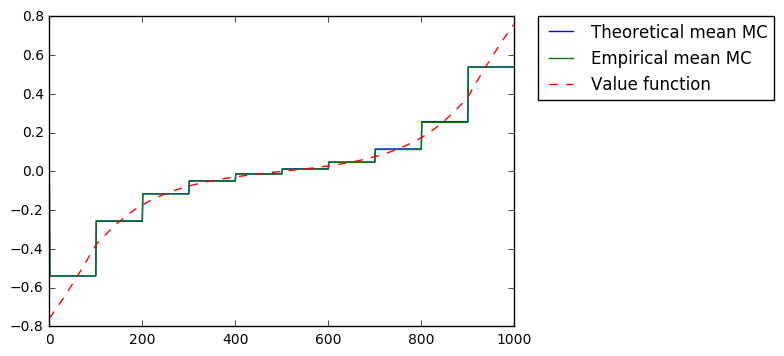

In [22]:
plt.plot(v_mc_exp[nEp_mc-1,:],label='Theoretical mean MC')
plt.plot(v_mc_emp[nEp_mc-1,:],label='Empirical mean MC')
plt.plot(v_pi[range(1,nState+1)], 'r--',label='Value function') #true value function
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

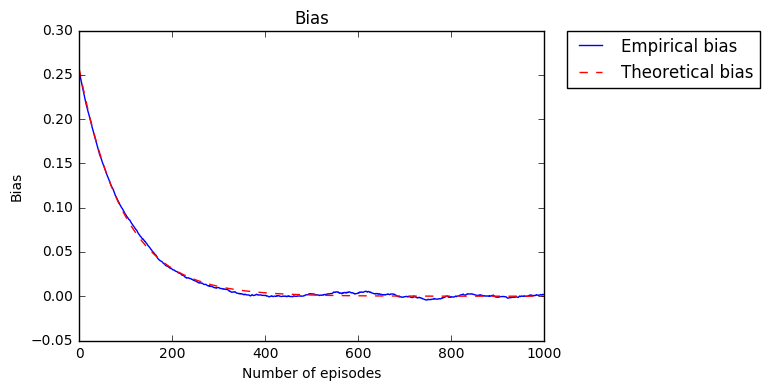

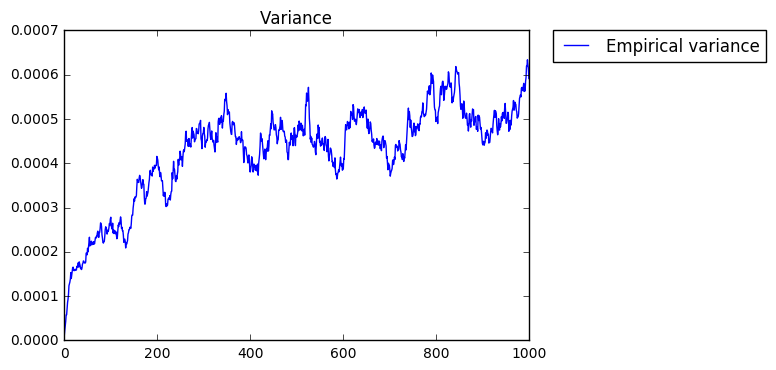

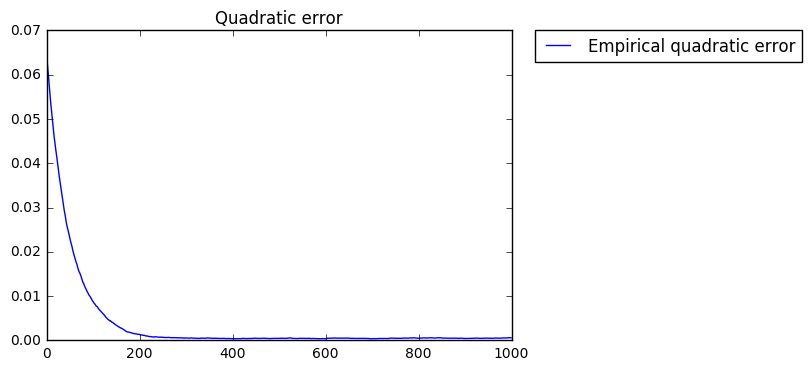

In [23]:
#compute empirical bias
bias_mc=np.mean(theta_save_mc,0)-theta_mc_star
#compute empirical variance
var_mc=np.var(theta_save_mc,0)
var_lowCI_mc=((nbRuns_mc-1)/(chi2.ppf(0.975,nbRuns_mc-1)))*var_mc
var_highCI_mc=((nbRuns_mc-1)/(chi2.ppf(0.025,nbRuns_mc-1)))*var_mc
#compute empirical quadratic error
mse_mc = var_mc+np.square(bias_mc)

param=2

plt.plot(bias_mc[range(nEp_mc),param],color='b',label='Empirical bias')
plt.plot(bias_mc_exp[range(nEp_mc),param],color='r',ls='--',label='Theoretical bias')
plt.title('Bias')
plt.xlabel('Number of episodes')
plt.ylabel('Bias')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(var_mc[range(nEp_mc),param],color='b',label='Empirical variance')
plt.title('Variance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(mse_mc[range(nEp_mc),param],color='b',label='Empirical quadratic error')
plt.title('Quadratic error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

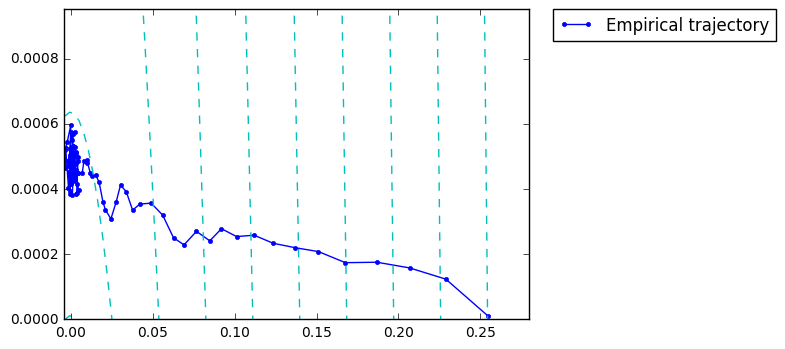

In [24]:
param=2
subset=10*np.arange(nEp_mc/10)
plt.plot(bias_mc[subset,param],var_mc[subset,param],marker='.',label='Empirical trajectory')

#draw MSE level lines
x_min=np.min(bias_mc[:,param])
x_max=np.max(np.abs(bias_mc[:,param]))
y_min=np.min(var_mc[:,param])
y_max=np.max(var_mc[:,param])
z_min=np.min(mse_mc[:,param])
z_max=np.max(mse_mc[:,param])

x=np.linspace(0.8*x_min,1.1*x_max,100)
for z in np.square(np.linspace(0.8*x_min,x_max,10)):
    plt.plot(x,z-np.square(x),color='c',ls='--')
    
plt.axis([0.9*x_min,1.1*x_max,0,1.5*y_max])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 4. Visualisation

We now present a way to visualize the previous analysis. To do so, we use the fact that $\Pi$ is the orthogonal projection over the image of $\Phi$.

## 4.1 Data scaling

Recall we are using the $D$-norm, and notice:
\begin{align}
<u,v>_{D} & = (u-v)^{T} \cdot D \cdot (u-v)\\
& =\big( \sqrt{D} \cdot (u-v) \big)^{T} \cdot \big( \sqrt{D}\cdot (u-v)\big)\\
& =< \sqrt{D} \cdot u, \sqrt{D} \cdot v >
\end{align}

where we use the following notation :
$$
\sqrt{D} = 
\left(
\begin{array}{ccc}
\sqrt{d(s_{1})} & & 0\\
& \ddots & \\
0 & & \sqrt{d(s_{|\mathcal{S}|})}
\end{array}
\right)
$$

So, we just have to scale our data before applying out-of-the box PCA. This way, it will be as if we were using PCA using the $D$-scalar product instead of the traditional one.

In [25]:
#first, we need to re-scale the data to apply out-of-the-box PCA
#applying standard scalar product to the scaled data is equivalent to applying D-scalar product to the original data

v_mc_scaled = v_mc*np.sqrt(d_)
v_mc_emp_scaled = v_mc_emp*np.sqrt(d_)
v_mc_exp_scaled = v_mc_exp*np.sqrt(d_)
v_pi_scaled = v_pi*np.sqrt(d_)

## 4.2 Principal Components Analysis

In [26]:
from sklearn import decomposition

In [27]:
#Identify principal plane in Phi's image
pca=decomposition.PCA(n_components=2)
pca.fit(v_mc_exp_scaled)
print(pca.explained_variance_ratio_)

[ 0.96636059  0.03296374]


## 4.3 Visualisation
Let's see what the approximated functions look like in the principal plane:

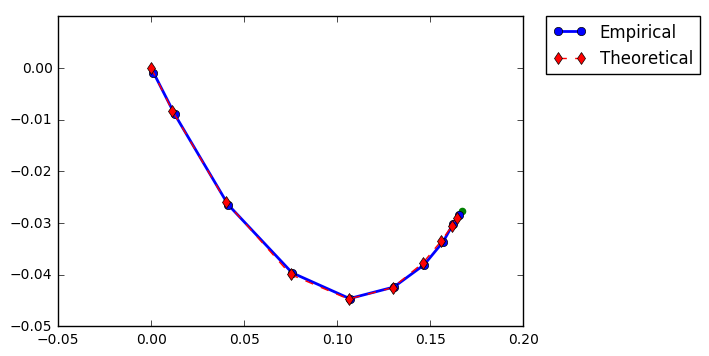

In [28]:
#extract PCA components
u_x=pca.components_[0,:] 
u_y=pca.components_[1,:] 
u_z = (v_pi_scaled-v_mc_scaled) / np.sqrt(((v_pi_scaled-v_mc_scaled).T.dot(D).dot((v_pi_scaled-v_mc_scaled))))

#Project on the principal plane 
v_mc_emp_scaled_proj_x=u_x.dot((v_mc_emp_scaled).T)
v_mc_emp_scaled_proj_y=u_y.dot((v_mc_emp_scaled).T)
v_mc_emp_scaled_proj_z=u_z.dot((v_mc_emp_scaled).T)

v_mc_exp_scaled_proj_x=u_x.dot((v_mc_exp_scaled).T)
v_mc_exp_scaled_proj_y=u_y.dot((v_mc_exp_scaled).T)
v_mc_exp_scaled_proj_z=u_z.dot((v_mc_exp_scaled).T)

#These bounds and ranges can be used to scale the plot axis
mean_x  = np.mean(v_mc_exp_scaled_proj_x)
mean_y  = np.mean(v_mc_exp_scaled_proj_y)
range_x = np.max(v_mc_exp_scaled_proj_x) - np.min(v_mc_exp_scaled_proj_x)
range_y = np.max(v_mc_exp_scaled_proj_y) - np.min(v_mc_exp_scaled_proj_y)

subset=10*np.square(np.arange(nEp_mc/100))

#plot the projection of MC

plt.plot(v_mc_emp_scaled_proj_x[subset],v_mc_emp_scaled_proj_y[subset],lw=2,marker='o',color='b',label='Empirical')
plt.plot(v_mc_exp_scaled_proj_x[subset],v_mc_exp_scaled_proj_y[subset],ls='--',marker='d',color='r',label='Theoretical')

#plot the projection of MC fixed point
plt.scatter(u_x.dot(v_mc_scaled),u_y.dot(v_mc_scaled),color='g') #Monte Carlo


#plt.axis([mean_x-range_x,mean_x+range_x,mean_y-range_y,mean_y+range_y]) #use if weird autoscaling
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()